# 混淆矩陣
<img src="image/confusionMatrix.png" width="400">  

* 精準度(precision): 所有預測為正，實際上為正的比率　$PRE = \frac{TP}{TP + FP}$  
* 召回率(recall): 所有實際上為正，被預測正確的比率　$REC = \frac{TP}{TP + FN}$
* F1-Score: 精準度與召回率的調和平均 $F1 = 2\frac{PRE \times REC}{PRE + REC}$

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#df = pd.read_csv('data/wdbc.data', header=None)
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

## Scikit-Learn 混淆矩陣

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[71  1]
 [ 2 40]]


## 混淆矩陣Matplot視覺化

<function matplotlib.pyplot.show(close=None, block=None)>

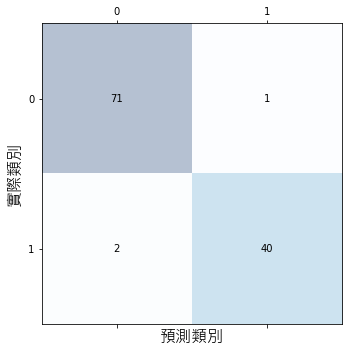

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('預測類別',fontproperties="Microsoft JhengHei",fontsize = 16)
plt.ylabel('實際類別',fontproperties="Microsoft JhengHei",fontsize = 16)

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show

## Scikit-Learn Pre,Rec,F1 Score

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('精確率Pre: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('召回率Rec: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1 Score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

精確率Pre: 0.976
召回率Rec: 0.952
F1 Score: 0.964


## 計分器Score

Sklearn 也有提供關於評估模型的估計器metrics.make_scorer，提供給GridSearchCV 和 cross_val_score使用，也可以在這邊將預設類別1為正改成0。

In [38]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## ROC曲線 
透過改變分類器門檻值觀察偽陽率和真陽率的的曲線，對角線可以被解釋成隨機猜測，如果曲線低於對角線則分類器比隨便瞎猜都還差，相反的曲線越靠近左上方則越好。
* AUC(Area Under the Curve): 曲線下的面積，面積越大代表曲線越靠近左上方，是衡量演算法的標準之一。

In [39]:
#設置plt中文
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('Microsoft JhengHei')

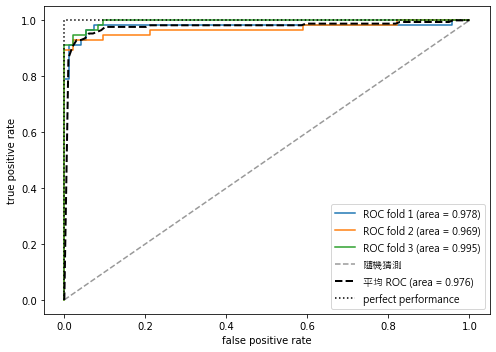

In [40]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import numpy as np
np.set_printoptions(suppress=True)#取消科學符號

pipe_lr = make_pipeline(StandardScaler(),
                       # PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           C=100.0,
                                           solver='liblinear'))    

kfold = list(StratifiedKFold(n_splits=3, 
                             random_state=1,shuffle=True).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(kfold):
    probas = pipe_lr.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test]) #回傳預測每個標籤的機率
    #fpr array, shape = [>2]
    #tp rarray, shape = [>2]
    #thresholds array, shape = [n_thresholds]
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1], #標籤為1的機率
                                     pos_label=1)
    #加總全部平均y軸的值(tpr) n_splits=3 總共100個點加總
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0 #重置第一個為0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.3f)'
                   % (i+1, roc_auc))
#隨機猜測對角線
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='隨機猜測')
#計算平均y軸值(tpr)
mean_tpr /= len(kfold)
#重置y軸最後一個值為1
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='平均 ROC (area = %0.3f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right",prop = fontP)

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

由ROC曲線圖可以知道每個fold都有變異，和每次抽出的資料不同有關。表現的最好是fold 3，它的ROC曲線最靠近左上角。總結來說3個fold都表現的不錯，平均AUC = 0.976。

### 直接計算AUC
直接使用sklearn.metrics.roc_auc_score

In [41]:
from sklearn.metrics import roc_auc_score

    

kfold = list(StratifiedKFold(n_splits=3, 
                             random_state=1,shuffle=True).split(X_train, y_train))



for i, (train, test) in enumerate(kfold):
    probas = pipe_lr.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test]) #回傳預測每個標籤的機率

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1], #標籤為1的機率
                                     pos_label=1)
    #加總全部平均y軸的值(tpr) n_splits=3 總共100個點加總
    roc_auc = roc_auc_score(y_train[test], probas[:,1])
    print('AUC fold %d:' % (i+1),roc_auc)


AUC fold 1: 0.9780240073868882
AUC fold 2: 0.9691597414589105
AUC fold 3: 0.9951127819548873


## 多類別分類(mutiple class)

* 宏觀平均(Macro averge): 將所有類別都視為相同重要性，類別不平衡時會有偏誤。  
$PRE_{macro} = \frac{PRE_1 + ... + PRE_k}{k}$  
* 微觀平均(Micro averge or Macro-weighted 加權宏觀): 將所有樣本視為相同重要性，處理類別不平時較優。
$PRE_{micro} = \frac{TP_1 + ... + TP_k}{TP_1 + ... + TP_k + FP_1 + ... + FP_k}$  


In [42]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')
#透過precision_score設定微觀平均，並包裝成估計器未來可以提供給GridSearchCV和cross_val_score使用

make_scorer(precision_score, pos_label=1, average=micro)